In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from viz import plot_campaign_budgets, plot_opinions_over_time
from rl_envs_forge.envs.network_graph.network_graph import NetworkGraph

from algos import *

In [3]:
def create_adjacency_matrix_from_links(num_nodes, links):
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    for link in links:
        from_node, to_node = link
        # adjacency_matrix[from_node, to_node] = 1
        adjacency_matrix[to_node, from_node] = 1

    return adjacency_matrix


def init_env():
    links = [
        (0, 2),
        (0, 4),
        (0, 5),
        (0, 6),
        (1, 3),
        (1, 8),
        (2, 0),
        (2, 1),
        (3, 0),
        (4, 0),
        (4, 5),
        (5, 4),
        (5, 10),
        (6, 4),
        (6, 9),
        (6, 11),
        (7, 5),
        (7, 8),
        (8, 1),
        (8, 5),
        (9, 6),
        (9, 12),
        (10, 5),
        (10, 7),
        (10, 13),
        (11, 5),
        (11, 6),
        (11, 7),
        (11, 14),
        (12, 8),
        (13, 5),
        (13, 11),
        (14, 5),
        (14, 11),
    ]

    num_nodes = 15
    connectivity_matrix = create_adjacency_matrix_from_links(num_nodes, links)
    # connectivity_matrix = normalize_adjacency_matrix(connectivity_matrix)

    # initial_opinions = np.linspace(0, 1, num_nodes)
    initial_opinions = (np.mod(np.arange(0, 0.1 * num_nodes, 0.1), 0.9)) + 0.1

    env = NetworkGraph(
        connectivity_matrix=connectivity_matrix,
        initial_opinions=initial_opinions,
        max_u=0.2,
        budget=100.0,
        desired_opinion=1.0,
        tau=0.5,
        max_steps=1_000_000,
    )

    env.reset()

    return env

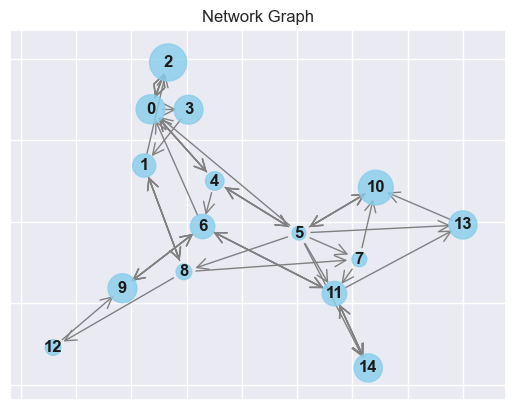

In [4]:
env = init_env()
env.render(mode="matplotlib")

c:\Users\Chainsword\anaconda3\envs\phd_rl_algos\Lib\site-packages\rl_envs_forge\envs\network_graph\visualize.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_labels, y=sorted_centralities, palette="Blues_d")


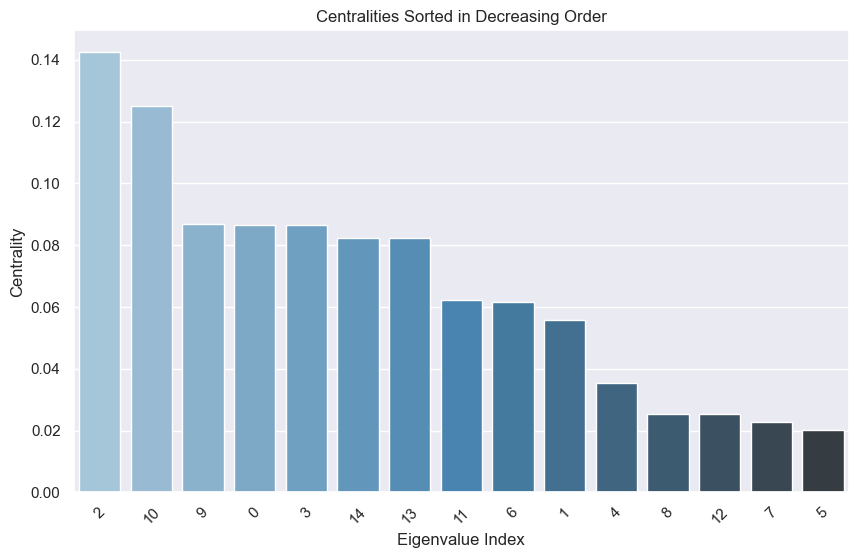

In [5]:
env.render(mode="centralities")

## Zero control 

Overall Error: 0.6351851720579025
Final Error: 0.6362022971019061


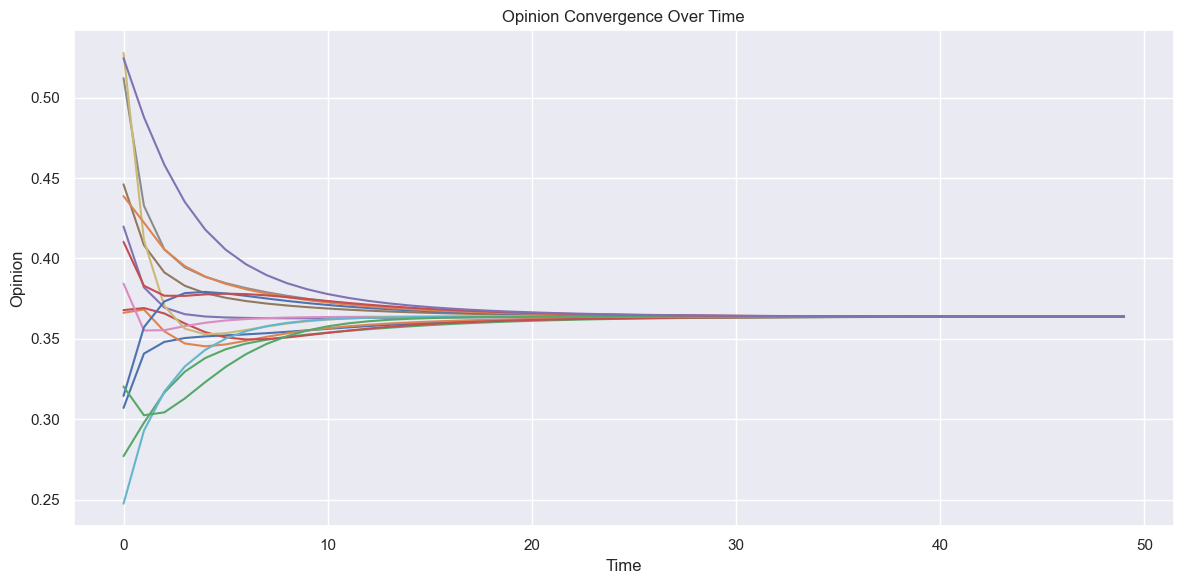

In [6]:
# Define the number of steps for which to apply the zero control input
env = init_env()

num_steps = 50

# Initialize an array to store opinions over time
opinions_over_time = np.zeros((num_steps, env.num_agents))

# Run the simulation with zero control input
for i in range(num_steps):
    no_action_u = np.zeros(env.num_agents)  # Zero control input
    opinions, reward, done, truncated, info = env.step(no_action_u)
    opinions_over_time[i] = opinions


overall_error_broadcast = compute_average_error(opinions_over_time, env.desired_opinion)
final_error_broadcast = compute_final_average_error(
    opinions_over_time, env.desired_opinion
)

print(f"Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time)

## Broadcast Strategy (use all available budget at start)

[0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
Broadcast Strategy - Overall Error: 0.5091689008926918
Final Error: 0.5089614557227136


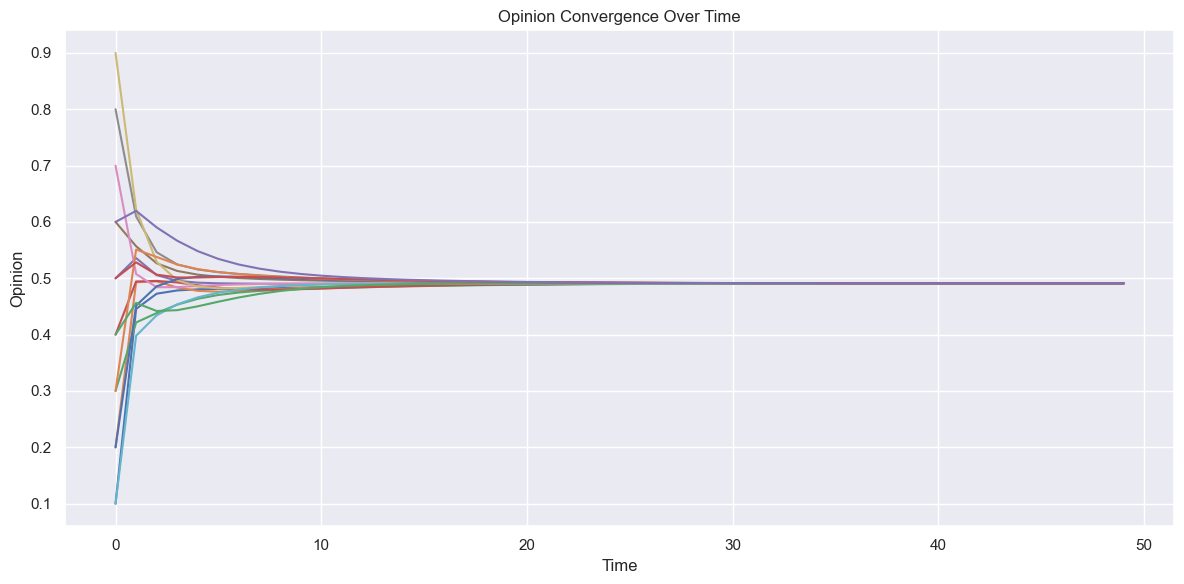

In [7]:
env = init_env()
num_steps = 50  # Total number of steps in the simulation
Q = 15  # Total budget

# Run the experiment with the broadcast strategy
opinions_over_time_broadcast, budget_distribution, affected_nodes = (
    run_broadcast_strategy(env, Q, num_steps)
)
overall_error_broadcast = compute_average_error(
    opinions_over_time_broadcast, env.desired_opinion
)
final_error_broadcast = compute_final_average_error(
    opinions_over_time_broadcast, env.desired_opinion
)

print(f"Broadcast Strategy - Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time_broadcast)

### Broadcast with single step

[0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
Broadcast Strategy - Overall Error: 0.5344809188407613
Final Error: 0.5089618376815227


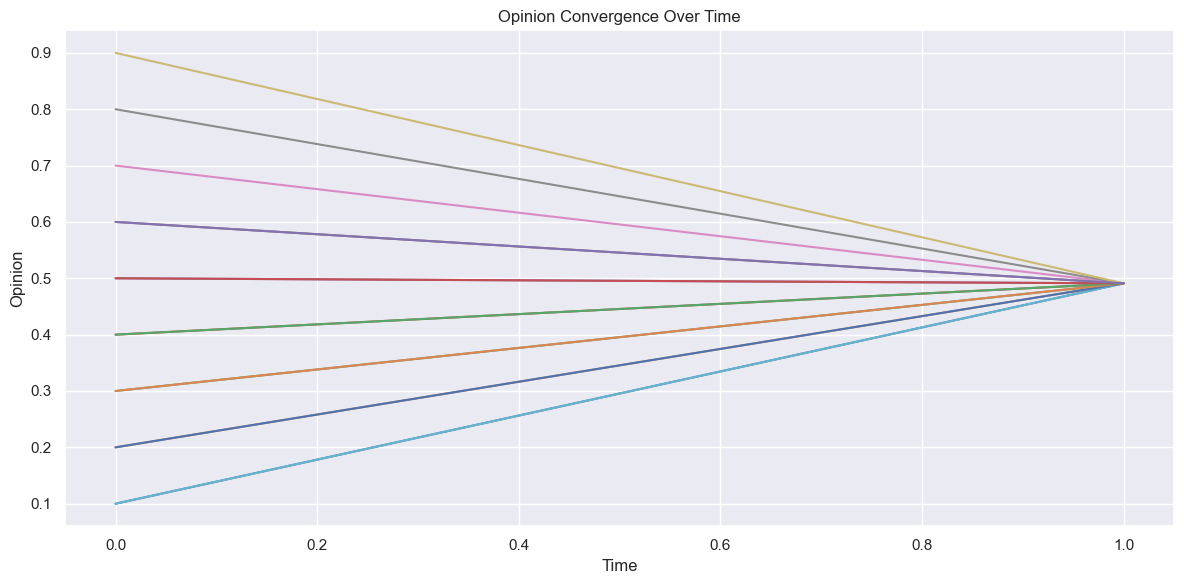

In [8]:
env = init_env()
num_steps = 50  # Total number of steps in the simulation
Q = 15  # Total budget

opinions_over_time = np.zeros((2, env.num_agents))

# Lists to store budget distribution and affected nodes
budget_distribution = []
affected_nodes = []

# Store opinions before applying the first control step
opinions_over_time[0] = env.opinions.copy()

# Calculate the control action using the total budget (units of u_max)
optimal_action, remaining_budget, controlled_agents = optimal_control_action(env, Q)
print(optimal_action)

# Apply the control for the first step
opinions, reward, done, truncated, info = env.step(
    optimal_action, step_duration=0.5 * num_steps
)
opinions_over_time[1] = opinions

# Track affected nodes and budget
affected_nodes.append(list(np.where(optimal_action > 0)[0]))
budget_distribution.append(np.sum(optimal_action))  # Budget used in the first step

overall_error_broadcast = compute_average_error(opinions_over_time, env.desired_opinion)
final_error_broadcast = compute_final_average_error(
    opinions_over_time, env.desired_opinion
)

print(f"Broadcast Strategy - Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time)

Broadcast Strategy with Sampling - Overall Error: 0.5095910779540515
Final Error: 0.5089621656219209


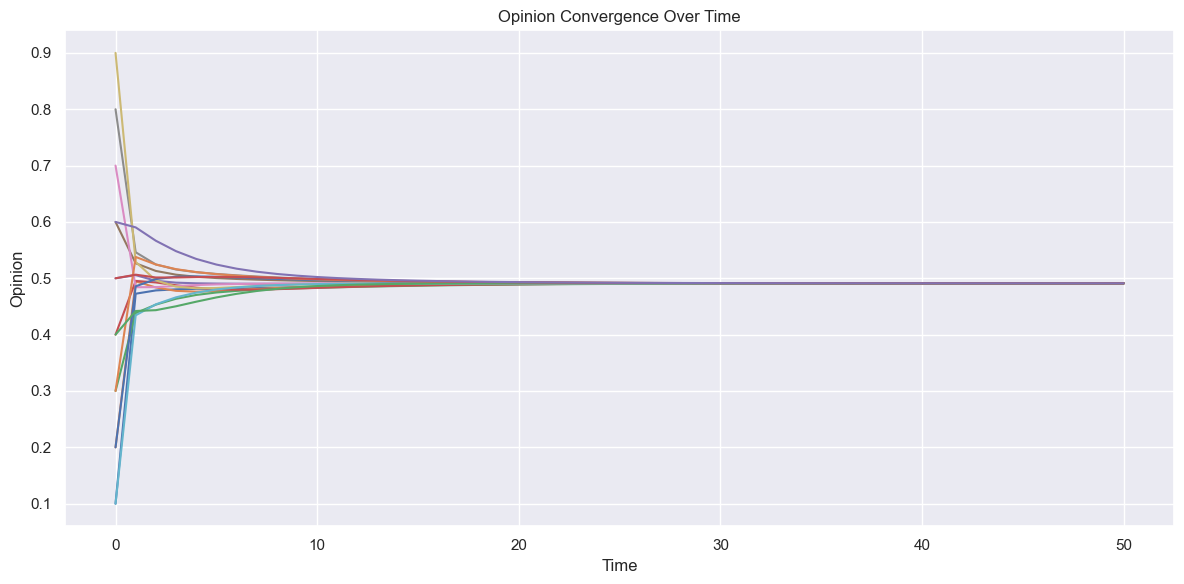

In [9]:
env = init_env()
num_steps = 50  # Total number of steps in the simulation

# Parameters
Q = 15  # Total budget (units of max_u)
step_duration = 0.5 * num_steps  # Total duration over multiple steps
sampling_time = 0.5


# Determine the control action using the total budget (units of max_u)
optimal_action, remaining_budget, controlled_agents = optimal_control_action(env, Q)

# Run the campaign with sampling
opinions_over_time, time_points = run_campaign_with_sampling(
    env,
    action=optimal_action,
    step_duration=step_duration,
    sampling_time=sampling_time,
)

# Compute errors
overall_error = compute_average_error(opinions_over_time, env.desired_opinion)
final_error = compute_final_average_error(opinions_over_time, env.desired_opinion)

print(f"Broadcast Strategy with Sampling - Overall Error: {overall_error}")
print(f"Final Error: {final_error}")
plot_opinions_over_time(opinions_over_time)

### DP

In [10]:
import numpy as np
from scipy.interpolate import interp1d


def dynamic_programming_with_grid(env, M, TB, nx=10):
    """
    Implement dynamic programming with state grid and budget.

    Args:
        env (NetworkGraph): The environment instance.
        M (int): Number of campaigns.
        K (int): Total budget.
        nx (int): Number of discretization points on the grid for x.

    Returns:
        V (ndarray): Value function of shape (M+1, nx, K+1).
        order, order0 (list): Sorted agent orders based on centrality and initial deviation.
    """
    N = env.num_agents
    ubar = env.max_u
    x0 = np.mean(env.opinions)
    xd = env.desired_opinion
    eigv = env.centralities

    # Grid for the state
    Xgrid = np.linspace(0, 1, nx)

    # Agent orderings based on centralities and initial influence powers
    order = np.argsort(eigv)[::-1]  # Descending order of centralities
    score0 = eigv * np.abs(x0 - xd)
    order0 = np.argsort(score0)[::-1]  # Descending order of score0

    uzero = np.zeros(N, dtype=np.float64)

    # Initialize value function V
    V = np.full((M + 1, nx, TB + 1), np.inf)

    # Final cost for the last stage (adjust to Python indexing)
    for ix in range(nx):
        V[M, ix, :] = np.abs(Xgrid[ix] - xd)

    # Backward induction from stage M-1 down to stage 2
    for k in range(M - 1, 0, -1):
        print(f"DP step {k}")
        for ix in range(nx):  # Loop over grid points for the current state
            for rem in range(TB + 1):  # Loop over remaining budget
                x = Xgrid[ix]
                val = np.inf
                u = uzero.copy()
                for beta in range(0, min(rem, N) + 1):
                    if beta > 0:
                        u[order[beta - 1]] = ubar
                    xplus = np.dot(eigv, u * xd + (1 - u) * x)
                    # xplus = np.clip(
                    #     xplus, Xgrid[0], Xgrid[-1]
                    # )
                    remplus = rem - beta

                    # Interpolate future cost
                    vplus = interp1d(
                        Xgrid,
                        V[k + 1, :, remplus],
                        kind="linear",
                        # fill_value="extrapolate",
                    )(xplus)
                    # vplus = np.interp(xplus, Xgrid, V[k + 1, :, remplus])
                    val = min(val, vplus)

                V[k, ix, rem] = val

    return V, order, order0


def forward_propagation_with_grid(env, V, order, order0, M, TB, nx=10):
    """
    Forward propagation from given initial state using dynamic programming results.

    Args:
        env (NetworkGraph): The environment instance.
        V (ndarray): Value function from dynamic programming.
        order (list): Agent order based on centrality.
        order0 (list): Agent order based on initial influence.
        M (int): Number of campaigns.
        TB (int): Total budget.
        nx (int): Number of discretization points on the grid for x.

    Returns:
        BETA (list): Optimal budget allocations.
        X (ndarray): State of the network after each campaign.
        U (ndarray): Control inputs applied to the agents.
        final_cost (float): Final cost (discrepancy from target opinion).
    """
    N = env.num_agents
    ubar = env.max_u
    x0 = np.mean(env.opinions)
    xd = env.desired_opinion
    eigv = env.centralities
    Xgrid = np.linspace(0, 1, nx)  # State grid

    X = np.zeros((N, M + 1))
    BETA = np.zeros(M, dtype=int)
    U = np.zeros((N, M))
    X[:, 0] = env.opinions.copy()  # Initial opinions
    rem = TB
    uzero = np.zeros(N, dtype=np.float64)
    # xplusstar = np.inf
    # betastar = 1
    # remstar = 0

    for k in range(M):
        val = np.inf
        ustar = uzero.copy()
        u = uzero.copy()
        for beta in range(0, min(rem, N - 1) + 1):
            if beta > 0:
                if k == 0:
                    u[order0[beta - 1]] = ubar
                else:
                    u[order[beta - 1]] = ubar
            xplus = np.dot(eigv, u * xd + (1 - u) * X[:, k])
            # xplus = np.clip(
            #     xplus, Xgrid[0], Xgrid[-1]
            # )
            remplus = rem - beta

            vplus = interp1d(
                Xgrid, V[k + 1, :, remplus], 
                kind="linear", 
                # fill_value="extrapolate"
            )(xplus)
            # vplus = np.interp(xplus, Xgrid, V[k + 1, :, remplus])
            if vplus < val:  # save best solution
                val = vplus
                xplusstar = xplus
                remstar = remplus
                ustar = u.copy()
                betastar = beta

        U[:, k] = ustar
        X[:, k + 1] = xplusstar
        BETA[k] = betastar
        rem = remstar

    final_cost = np.abs(np.mean(X[:, -1]) - xd)
    return BETA, U, X, final_cost


# Initialize environment
env = init_env()

# Parameters
M = 4  # Number of campaigns
TB = 15  # Total budget
nx = 100  # Number of grid points
ubar = env.max_u

# Run dynamic programming
V, order, order0 = dynamic_programming_with_grid(env, M, TB, nx=nx)

# Forward propagation to compute optimal budget allocation and final cost
optimal_budget_allocation, U, X, final_cost = forward_propagation_with_grid(
    env, V, order, order0, M, TB, nx=nx
)

# Print results
print("Optimal Budget Allocation:", optimal_budget_allocation)
print("Final Cost:", final_cost)

DP step 3
DP step 2
DP step 1
Optimal Budget Allocation: [4 2 2 7]
Final Cost: 0.4362480722097607


In [11]:
# from algos import dynamic_programming_strategy, extract_optimal_policy, compute_expected_value_for_budget_distribution

env = init_env()
M = 4
Q = 15
step_duration = 30

(
    policy,
    Xgrid,
    V,
) = dynamic_programming_strategy(env, M, Q, step_duration)

optimal_budget_allocation, nodes_controlled, control_inputs, final_opinion_error, X = (
    extract_optimal_policy(policy, env, Xgrid, V, M, Q, step_duration)
)
print(optimal_budget_allocation)
print(nodes_controlled)

DP step 4
DP step 3
DP step 2
DP step 1
[5, 6, 2, 2]
[array([ 0,  2,  3,  9, 10], dtype=int64), array([ 0,  2,  3,  9, 10, 14], dtype=int64), array([ 2, 10], dtype=int64), array([ 2, 10], dtype=int64)]


In [12]:
final_opinion_error, total_cost, costs, X = (
    compute_expected_value_for_budget_distribution(
        optimal_budget_allocation, env, M, step_duration
    )
)


final_opinion_error

0.4364072006468873

In [13]:
final_opinion_error, total_cost, costs, X = (
    compute_expected_value_for_budget_distribution([4, 2, 2, 7], env, M, step_duration)
)


final_opinion_error

0.43624796532657906

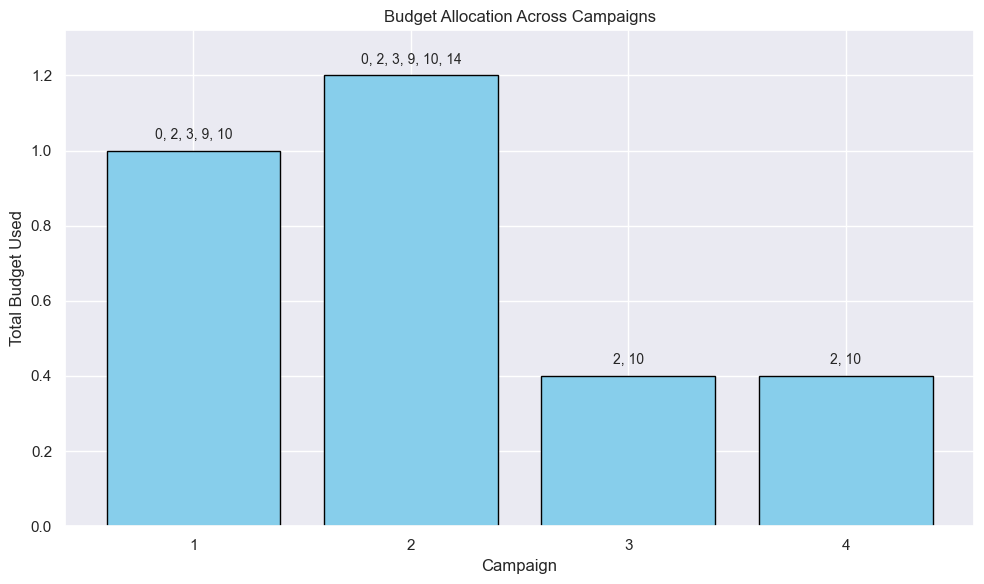

In [14]:
plot_campaign_budgets(optimal_budget_allocation, nodes_controlled, control_inputs)

Dynamic Programming Strategy - Overall Error: 0.4850850106861192
Final Error: 0.43640719618549634
[array([ 0,  2,  3,  9, 10], dtype=int64), array([ 0,  2,  3,  9, 10, 13], dtype=int64), array([ 2, 10], dtype=int64), array([ 2, 10], dtype=int64)]


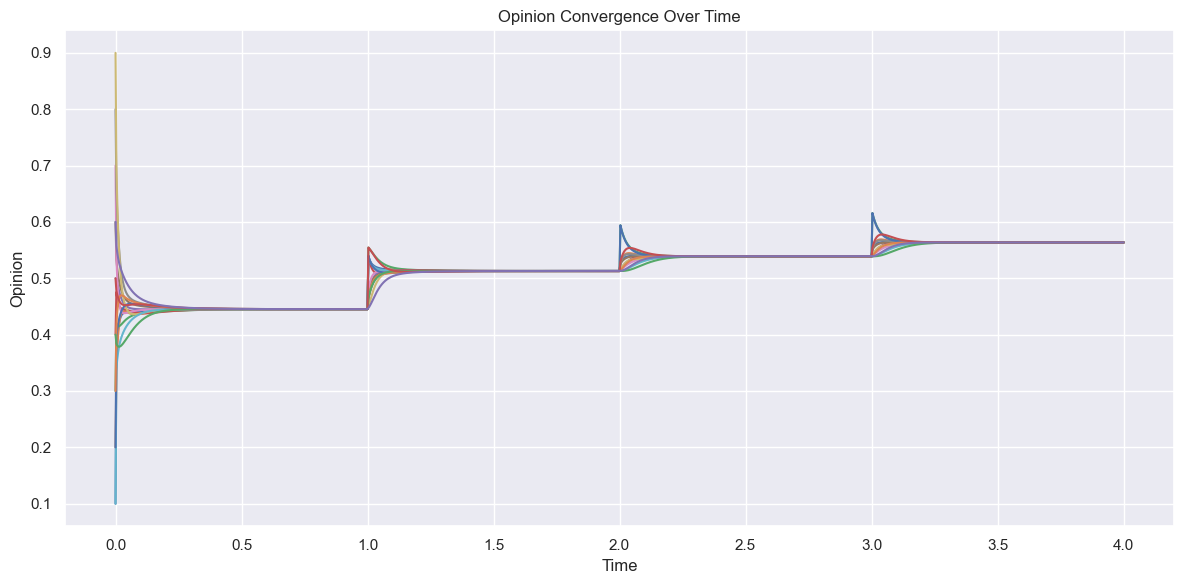

In [15]:
from algos import normalize_campaign_time, run_dynamic_programming_campaigns

env = init_env()

step_duration = 30
sampling_time = 0.1
final_campaign_step_duration = 30  # Longer duration for the final campaign
final_campaign_sampling_time = sampling_time

# Run the campaigns using the optimal budget allocations
opinions_over_time_dp, time_points_dp, nodes_controlled_simulation = (
    run_dynamic_programming_campaigns(
        env,
        optimal_budget_allocation,
        step_duration,
        sampling_time,
        final_campaign_step_duration=final_campaign_step_duration,
        final_campaign_sampling_time=final_campaign_sampling_time,
    )
)

# Compute errors
overall_error_dp = compute_average_error(opinions_over_time_dp, env.desired_opinion)
final_error_dp = compute_final_average_error(opinions_over_time_dp, env.desired_opinion)

print(f"Dynamic Programming Strategy - Overall Error: {overall_error_dp}")
print(f"Final Error: {final_error_dp}")

# Compute campaign durations
campaign_durations = [step_duration] * (M - 1) + [final_campaign_step_duration]
normalized_time_points_dp = normalize_campaign_time(
    time_points_dp, campaign_durations, step_duration, final_campaign_step_duration
)

print(nodes_controlled_simulation)

# plot_opinions_over_time(opinions_over_time_dp, time_points_dp)
plot_opinions_over_time(opinions_over_time_dp, normalized_time_points_dp)

Dynamic Programming Strategy - Overall Error: 0.5108076183021965
Final Error: 0.4362479685370565
[array([ 0,  2,  9, 10], dtype=int64), array([ 2, 10], dtype=int64), array([ 2, 10], dtype=int64), array([ 0,  2,  3,  9, 10, 13, 14], dtype=int64)]


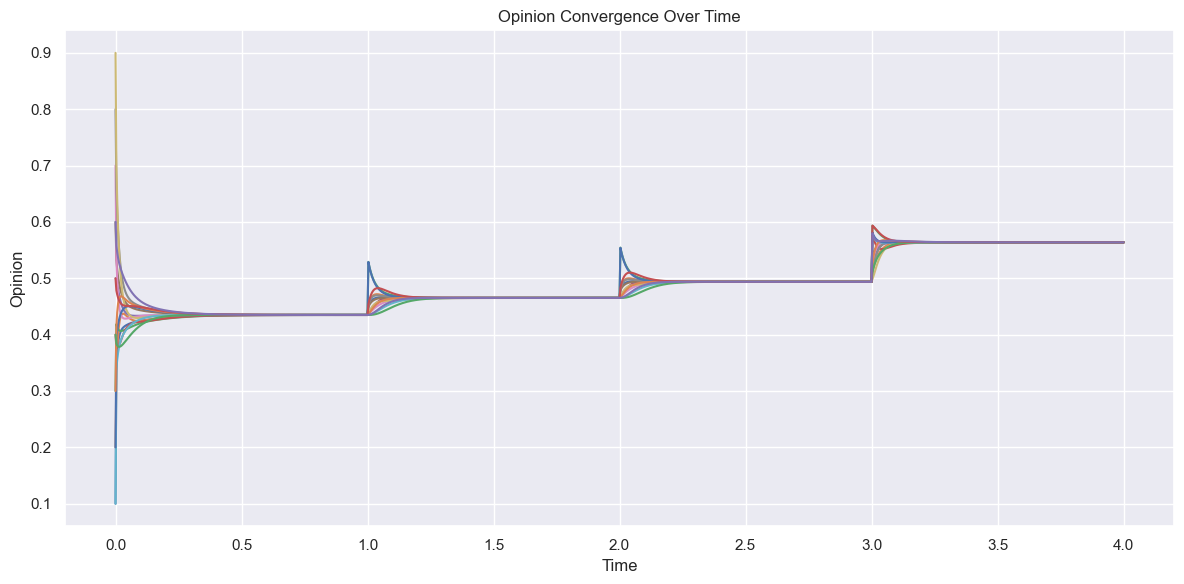

In [16]:
# from algos import run_dynamic_programming_campaigns

handmade_budget_allocation = [4, 2, 2, 7]

env = init_env()

step_duration = 30
sampling_time = 0.1
final_campaign_step_duration = 30  # Longer duration for the final campaign
final_campaign_sampling_time = sampling_time

# Run the campaigns using the optimal budget allocations
opinions_over_time_dp, time_points_dp, nodes_controlled_simulation = (
    run_dynamic_programming_campaigns(
        env,
        handmade_budget_allocation,
        step_duration,
        sampling_time,
        final_campaign_step_duration=final_campaign_step_duration,
        final_campaign_sampling_time=final_campaign_sampling_time,
    )
)

# Compute errors
overall_error_dp = compute_average_error(opinions_over_time_dp, env.desired_opinion)
final_error_dp = compute_final_average_error(opinions_over_time_dp, env.desired_opinion)

print(f"Dynamic Programming Strategy - Overall Error: {overall_error_dp}")
print(f"Final Error: {final_error_dp}")

# Compute campaign durations
campaign_durations = [step_duration] * (M - 1) + [final_campaign_step_duration]
normalized_time_points_dp = normalize_campaign_time(
    time_points_dp, campaign_durations, step_duration, final_campaign_step_duration
)

print(nodes_controlled_simulation)

# plot_opinions_over_time(opinions_over_time_dp, time_points_dp)
plot_opinions_over_time(opinions_over_time_dp, normalized_time_points_dp)

In [17]:
# ### Brute force search

# from itertools import product
# from algos import run_dynamic_programming_campaigns, compute_average_error, compute_final_average_error
# from viz import plot_opinions_over_time
# from tqdm import tqdm

# # Define parameters
# total_budget = 15
# num_campaigns = 4  # Number of campaigns
# step_duration = 30
# final_campaign_step_duration = 30  # Longer duration for the final campaign
# sampling_time = 0.1
# final_campaign_sampling_time = 0.1

# # Initialize environment
# env = init_env()

# # Function to generate all valid budget allocations
# def generate_valid_budget_allocations(total_budget, num_campaigns):
#     """Generate all budget combinations where the sum of budgets is <= total_budget."""
#     allocations = []
#     for allocation in product(range(total_budget + 1), repeat=num_campaigns):
#         if sum(allocation) <= total_budget:
#             allocations.append(allocation)
#     return allocations

# # Get all valid budget allocations
# valid_budget_allocations = generate_valid_budget_allocations(total_budget, num_campaigns)

# # Store all results: budget combination and corresponding final error
# results = []

# # Brute-force search over all budget allocations
# for budget_allocation in tqdm(valid_budget_allocations, desc="Running Campaigns"):
#     # Reset environment for each test
#     env = init_env()

#     # Run the campaigns using the current budget allocation
#     opinions_over_time, time_points, nodes_controlled_simulation = run_dynamic_programming_campaigns(
#         env,
#         budget_allocation,
#         step_duration,
#         sampling_time,
#         final_campaign_step_duration=final_campaign_step_duration,
#         final_campaign_sampling_time=final_campaign_sampling_time,
#     )

#     # Compute final error
#     final_error = compute_final_average_error(opinions_over_time, env.desired_opinion)

#     # Store the result as a tuple of (budget_allocation, final_error)
#     results.append((budget_allocation, final_error))

# # Sort results by final error (ascending)
# results_sorted_by_error = sorted(results, key=lambda x: x[1])

# # Function to display top N budget combinations
# def show_top_n_budget_combinations(results_sorted, top_n=5):
#     print(f"Top {top_n} Budget Combinations by Final Error:")
#     for i in range(min(top_n, len(results_sorted))):
#         budget_allocation, final_error = results_sorted[i]
#         print(f"Rank {i+1}: Budget: {budget_allocation}, Final Error: {final_error}")

# # Display the top N budget combinations
# show_top_n_budget_combinations(results_sorted_by_error, top_n=5)

In [18]:
# results_sorted_by_error

In [19]:
def dynamic_programming_dp(env, M, Q, ubar, d):
    N = env.num_agents
    centralities = env.centralities.astype(np.float64)
    sorted_indices = np.argsort(-centralities)  # Descending order
    v_sorted = centralities[sorted_indices]
    cumulative_v = np.cumsum(v_sorted)

    # Initialize value functions and policy
    V = [{} for _ in range(M + 1)]  # V[0] to V[M]
    V[M][0] = (0.0, None)  # Final stage at k = M

    # Backward induction
    for k in range(M - 1, -1, -1):  # k = M - 1 down to 0
        V_curr = V[k]
        V_next = V[k + 1]
        for r_k in range(Q + 1):
            for b_k in range(0, min(r_k, N) + 1):
                r_k_next = r_k - b_k
                if r_k_next in V_next:
                    if k == 0:
                        # For the initial stage, compute y1
                        y1 = f0(
                            b_k,
                            env.opinions,
                            d,
                            ubar,
                            v_sorted,
                            cumulative_v,
                            env,
                            sorted_indices,
                        )
                        if y1 == 0:
                            continue  # Avoid log(0)
                        cost = np.log(np.abs(y1)) + V_next[r_k_next][0]
                    else:
                        f_bk = f(b_k, ubar, cumulative_v)
                        if f_bk == 0:
                            continue  # Avoid log(0)
                        cost = np.log(f_bk) + V_next[r_k_next][0]
                    if (r_k not in V_curr) or (cost < V_curr[r_k][0]):
                        V_curr[r_k] = (cost, b_k)
        V[k] = V_curr

    # Extract the optimal policy
    policy = []
    r_k = Q
    for k in range(0, M):
        if r_k not in V[k]:
            break
        cost, b_k = V[k][r_k]
        policy.append(b_k)
        r_k = r_k - b_k
    total_cost = V[0][Q][0]

    return policy, total_cost


def f0(b0, x0, d, ubar, v_sorted, cumulative_v, env, sorted_indices):
    N = env.num_agents
    u = np.zeros(N, dtype=np.float64)
    if b0 > 0:
        u[sorted_indices[:b0]] = ubar
    x_plus = u * d + (1 - u) * x0
    y1 = d - np.dot(env.centralities, x_plus)
    return y1


def f(b, ubar, cumulative_v):
    if b == 0:
        return 1.0
    else:
        v_sum = cumulative_v[b - 1]
        return (1 - ubar) ** v_sum


def compute_final_deviation_simulation(env, policy, ubar, d, Tlong):
    N = env.num_agents
    L = env.L.astype(np.float64)
    expL = expm(-L * Tlong)
    x = env.opinions.astype(np.float64)

    for k, b_k in enumerate(policy):
        # Determine the control action
        deviations = np.abs(x - d)
        if k == 0:
            # Order agents based on initial influence powers
            influence_powers = env.centralities * deviations
            agent_order = np.argsort(influence_powers)[::-1]
        else:
            # Order agents based on centralities
            agent_order = np.argsort(env.centralities)[::-1]

        u = np.zeros(N, dtype=np.float64)
        if b_k > 0:
            u[agent_order[:b_k]] = ubar

        # Apply control and propagate opinions
        x = u * d + (1 - u) * x
        x = expL @ x  # Propagate through network dynamics

    # Compute final opinion error
    final_opinion_error = np.abs(np.mean(x) - d)
    return final_opinion_error


# Usage example
env = init_env()
M = 4
Q = 15
ubar = env.max_u
Tlong = 30
d = env.desired_opinion

policy, total_cost = dynamic_programming_dp(env, M, Q, ubar, d)
final_opinion_error = compute_final_deviation_simulation(env, policy, ubar, d, Tlong=30)

print("Optimal Budget Allocation:", policy)
print("Final Opinion Error:", final_opinion_error)

Optimal Budget Allocation: [4, 3, 4, 4]
Final Opinion Error: 0.4365903743775028


In [20]:
policy = [4, 2, 2, 7]
final_opinion_error = compute_final_deviation_simulation(env, policy, ubar, d, Tlong=30)

print("Final Opinion Error:", final_opinion_error)

Final Opinion Error: 0.43624796532657906
